## Inception/GoogLeNet implementation with keras and CIFAR10 dataset

### 1. Load and preprocessing dataset

CIFAR10 is one of the most famous datasets in the field of machine learning
 - It has 60,000 images
 - Very straight forward to download
 - Images dimensions are 32x32
 - Colour images
 - 10 classes

In [43]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import numpy as np
import cv2

def load_cifar10_data(img_rows, img_cols):
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()

    #images resize
    x_train = np.array([cv2.resize(img, (img_rows, img_cols)) for img in x_train])
    x_test = np.array([cv2.resize(img, (img_rows, img_cols)) for img in x_test])

    #labels encoding (One-Hot)
    num_classes = len(np.unique(y_train))
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)

    #data normalization
    mean = np.mean(x_train)
    std = np.std(x_train)

    x_train = (x_train-mean)/(std+1e-7)
    x_test = (x_test-mean)/(std+1e-7)

    #split data
    x_train, x_valid = x_train[5000:], x_train[:5000]
    y_train, y_valid = y_train[5000:], y_train[:5000]

    return (x_train, y_train), (x_test, y_test), (x_valid, y_valid)
    
(x_train, y_train), (x_test, y_test), (x_valid, y_valid) = load_cifar10_data(img_rows=224, img_cols=224)

In [44]:
print("x_train shape:",x_train.shape,"y_train shape:",y_train.shape)
print("x_valid shape:",x_valid.shape,"y_valid shape:",y_valid.shape)
print("x_test shape:",x_test.shape,"y_test shape:",y_test.shape)

x_train shape: (45000, 32, 32, 3) y_train shape: (45000, 10)
x_valid shape: (5000, 32, 32, 3) y_valid shape: (5000, 10)
x_test shape: (10000, 32, 32, 3) y_test shape: (10000, 10)


### 2. Data visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

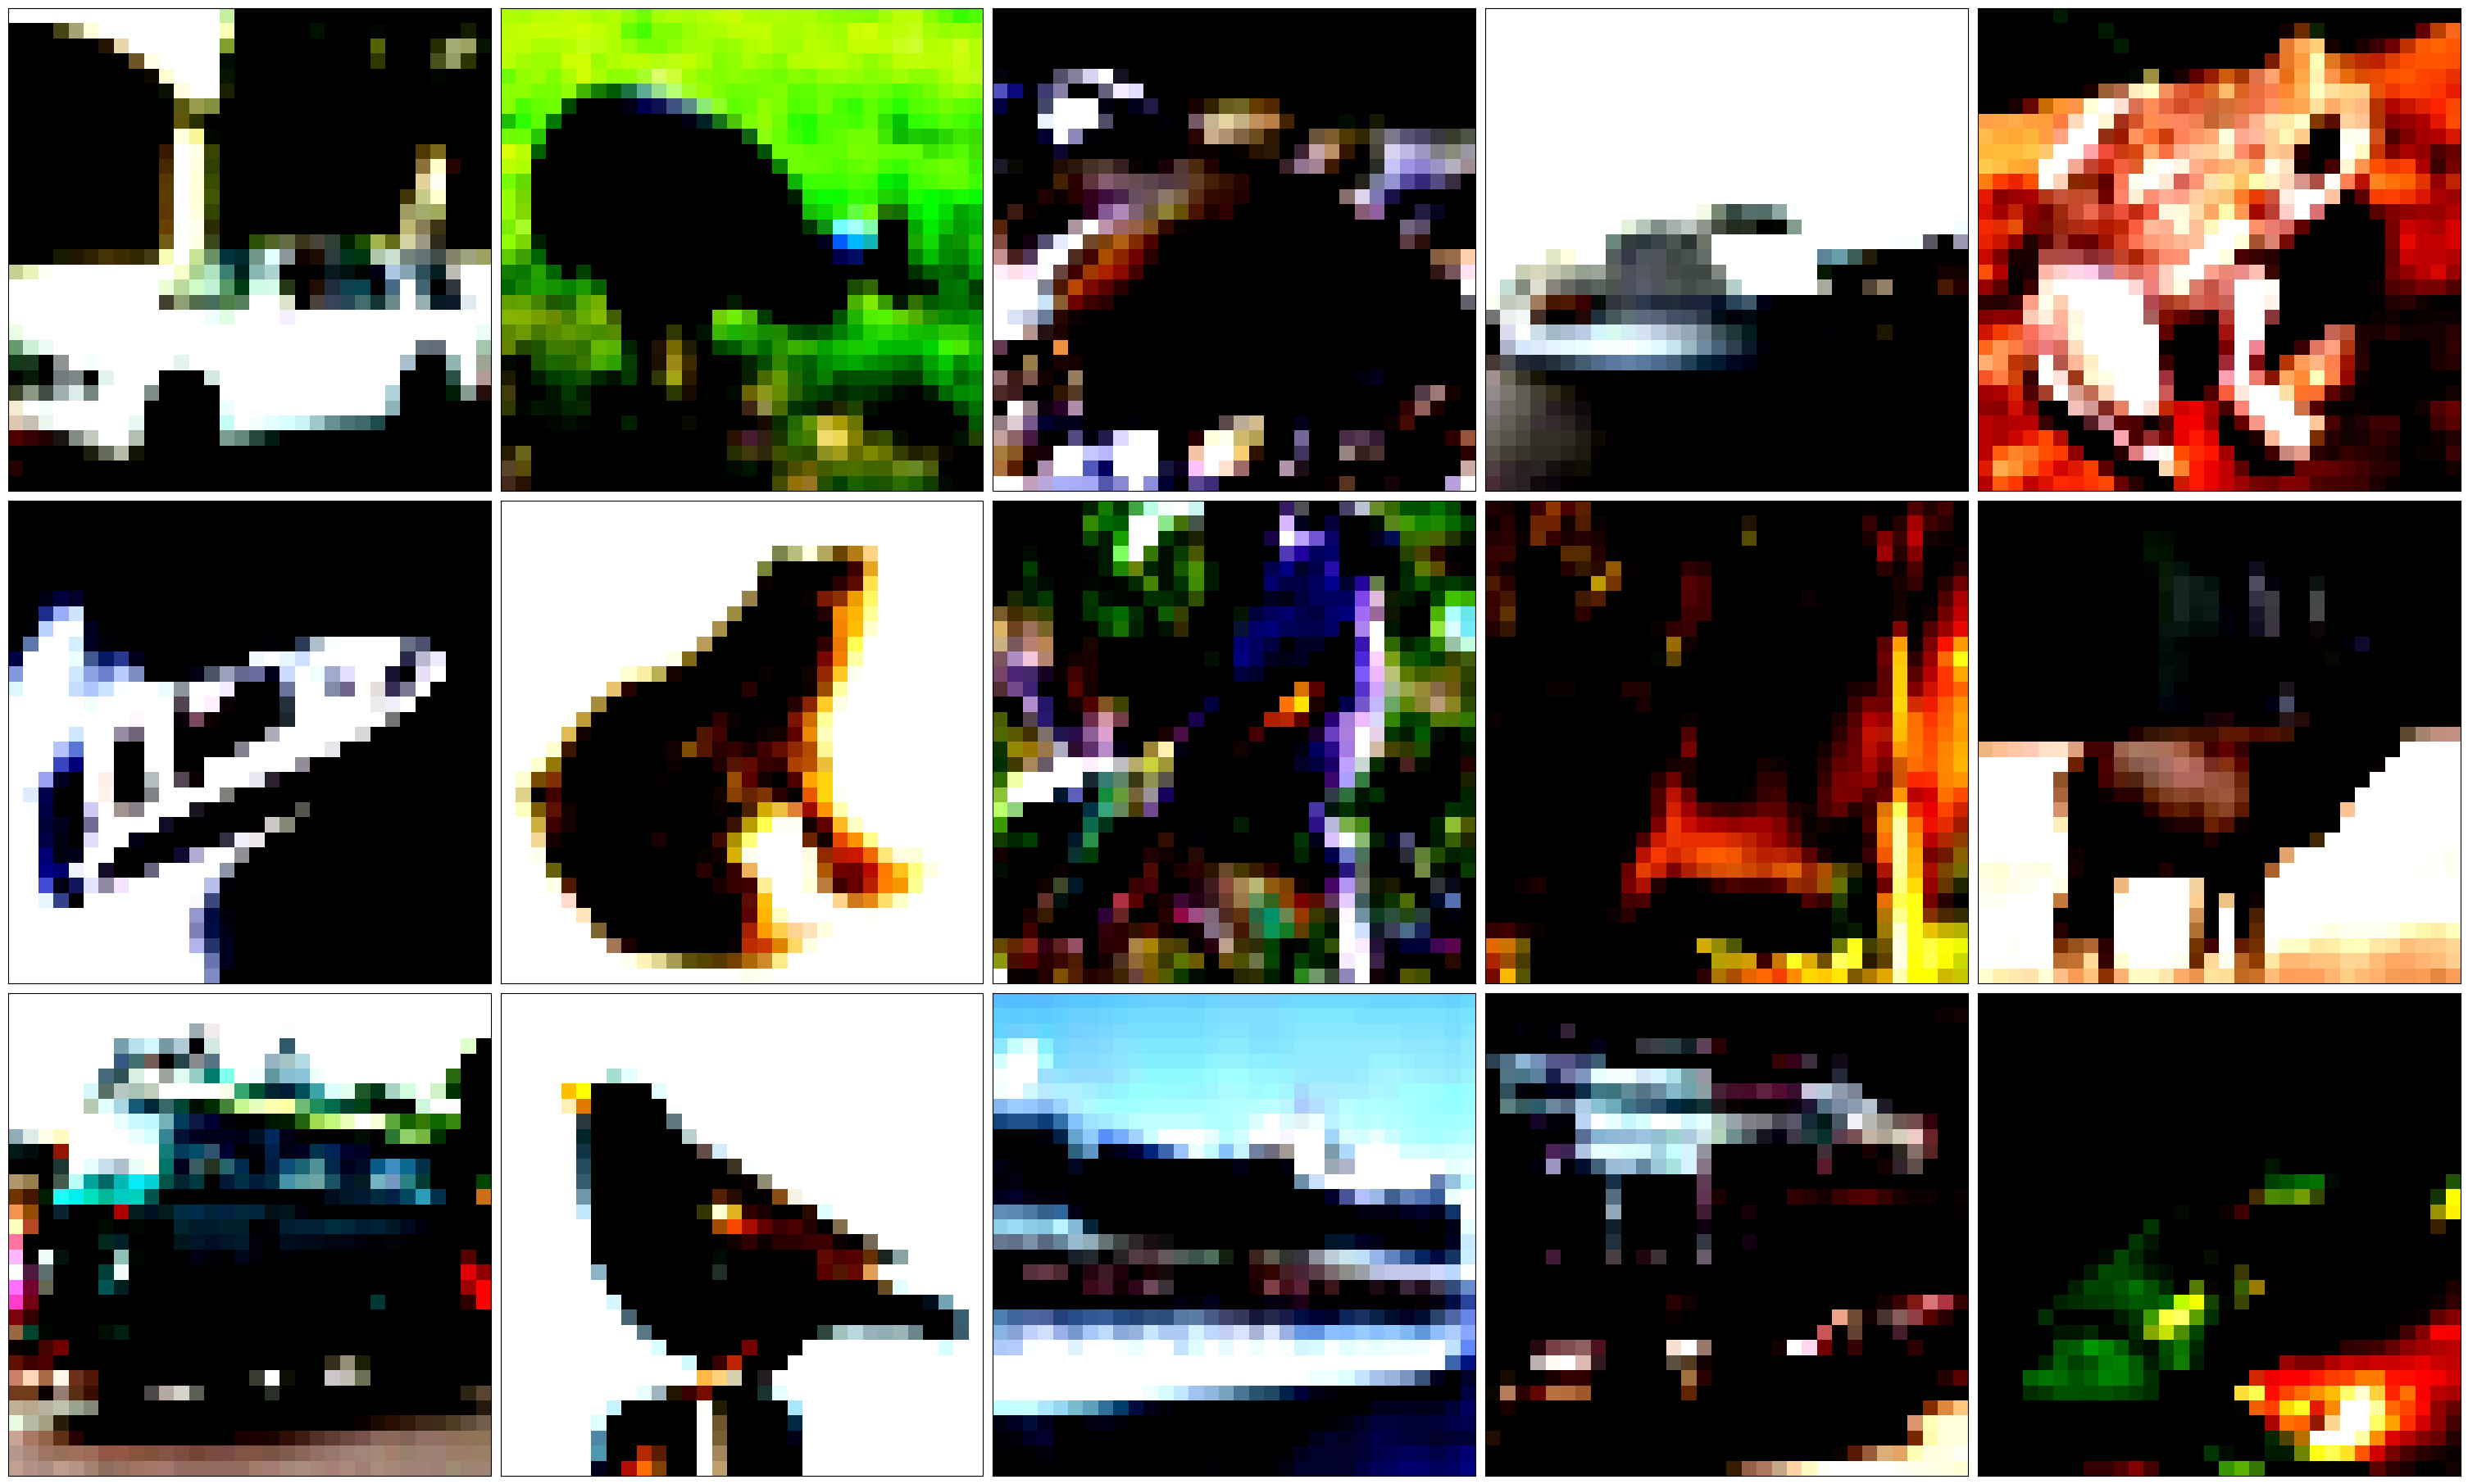

In [45]:
import matplotlib.pyplot as plt

fig , axs = plt.subplots(3,5,layout='constrained',figsize=(30,18))
for i,j in enumerate(np.random.choice(x_train.shape[0], size=15, replace=True)):
    axs.flat[i].imshow(x_train[j])
    axs.flat[i].tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)

### 3. Inception module with dimensionality reduction

<center><img src="./images/inception_module.png" alt="inception_module" width="600" height="auto"></center>

In [46]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, concatenate

def inception_module(x,
                filters_1x1,
                filters_3x3_reduce, filters_3x3,
                filters_5x5_reduce, filters_5x5,
                filters_max_pool_reduce,
                name=None):

    conv_1x1 = Conv2D(filters=filters_1x1, kernel_size=(1,1), strides=(1,1), padding='same', activation='relu',
                kernel_initializer=kernel_init, bias_initializer=bias_init)(x)

    conv_3x3_reduce = Conv2D(filters=filters_3x3_reduce, kernel_size=(1,1), strides=(1,1), padding='same', activation='relu',
                kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters=filters_3x3, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu',
                kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3_reduce)

    conv_5x5_reduce = Conv2D(filters=filters_5x5_reduce, kernel_size=(1,1), strides=(1,1), padding='same', activation='relu',
                kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters=filters_5x5, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu',
                kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5_reduce)

    max_pool = MaxPool2D(pool_size=(3,3), strides=(1,1), padding='same')(x)
    max_pool_reduce = Conv2D(filters=filters_max_pool_reduce, kernel_size=(1,1), strides=(1,1), padding='same', activation='relu',
                kernel_initializer=kernel_init, bias_initializer=bias_init)(max_pool)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, max_pool_reduce], axis=3, name=name)

    return output

### 4. GoogLeNet architecture

<center><img src="./images/googlenet_architecture.png" alt="inception_module" width="800" height="auto"></center>

In [50]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, AveragePooling2D, Flatten, Dropout, Dense
from tensorflow.keras.initializers import GlorotUniform, Constant

kernel_init = GlorotUniform()
bias_init = Constant(value=0.2)

input_layer = Input(shape=(224,224,3))

#Part A
x = Conv2D(filters=64, kernel_size=(7,7), strides=(2,2), padding='same', activation='relu',
        kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = MaxPool2D(pool_size=(3,3), strides=(2,2), padding='same')(x)
x = Conv2D(filters=64, kernel_size=(1,1), strides=(1,1), padding='same', activation='relu')(x)
x = Conv2D(filters=192, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(x)
x = MaxPool2D(pool_size=(3,3), strides=(2,2), padding='same')(x)

#Part B
x = inception_module(x,
                filters_1x1=64,
                filters_3x3_reduce=96, filters_3x3=128,
                filters_5x5_reduce=16, filters_5x5=32,
                filters_max_pool_reduce=32,
                name='3a')

x = inception_module(x,
                filters_1x1=128,
                filters_3x3_reduce=128, filters_3x3=192,
                filters_5x5_reduce=32, filters_5x5=96,
                filters_max_pool_reduce=64,
                name='3b')

x = MaxPool2D(pool_size=(3,3), strides=(2,2), padding='same')(x)

x = inception_module(x,
                filters_1x1=192,
                filters_3x3_reduce=96, filters_3x3=208,
                filters_5x5_reduce=16, filters_5x5=48,
                filters_max_pool_reduce=64,
                name='4a')

classifier_1 = AveragePooling2D(pool_size=(5,5), strides=(3,3), padding='valid')(x)
classifier_1 = Conv2D(filters=128, kernel_size=(1,1), strides=(1,1), padding='same', activation='relu')(classifier_1)
classifier_1 = Flatten()(classifier_1)
classifier_1 = Dense(1024, activation='relu')(classifier_1)
classifier_1 = Dropout(rate=0.7)(classifier_1)
classifier_1 = Dense(1000, activation='softmax')(classifier_1)

x = inception_module(x,
                filters_1x1=160,
                filters_3x3_reduce=112, filters_3x3=224,
                filters_5x5_reduce=24, filters_5x5=64,
                filters_max_pool_reduce=64,
                name='4b')

x = inception_module(x,
                filters_1x1=128,
                filters_3x3_reduce=128, filters_3x3=256,
                filters_5x5_reduce=24, filters_5x5=64,
                filters_max_pool_reduce=64,
                name='4c')

x = inception_module(x,
                filters_1x1=112,
                filters_3x3_reduce=144, filters_3x3=288,
                filters_5x5_reduce=32, filters_5x5=64,
                filters_max_pool_reduce=64,
                name='4d')

classifier_2 = AveragePooling2D(pool_size=(5,5), strides=(3,3), padding='valid')(x)
classifier_2 = Conv2D(filters=128, kernel_size=(1,1), strides=(1,1), padding='same', activation='relu')(classifier_2)
classifier_2 = Flatten()(classifier_2)
classifier_2 = Dense(1024, activation='relu')(classifier_2)
classifier_2 = Dropout(rate=0.7)(classifier_2)
classifier_2 = Dense(1000, activation='softmax')(classifier_2)

x = inception_module(x,
                filters_1x1=256,
                filters_3x3_reduce=160, filters_3x3=320,
                filters_5x5_reduce=32, filters_5x5=128,
                filters_max_pool_reduce=128,
                name='4e')

x = MaxPool2D(pool_size=(3,3), strides=(2,2), padding='same')(x)

x = inception_module(x,
                filters_1x1=256,
                filters_3x3_reduce=160, filters_3x3=320,
                filters_5x5_reduce=32, filters_5x5=128,
                filters_max_pool_reduce=128,
                name='5a')

x = inception_module(x,
                filters_1x1=384,
                filters_3x3_reduce=192, filters_3x3=384,
                filters_5x5_reduce=48, filters_5x5=128,
                filters_max_pool_reduce=128,
                name='5b')

#Part C
x = AveragePooling2D(pool_size=(7,7), strides=(1,1), padding='valid')(x)
x = Dropout(rate=0.4)(x)
x = Dense(1000, activation='relu')(x)
x = Dense(1000, activation='softmax')(x)

googlenet = Model(inputs=input_layer, outputs = [x,classifier_1,classifier_2])
googlenet.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_866 (Conv2D) │ (None, 112, 112,  │      9,472 │ input_layer_16[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_198   │ (None, 56, 56,    │          0 │ conv2d_866[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_867 (Conv2D) │ (None, 56, 56,    │      4,160 │ max_pooling2d_19… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_868 (Conv2D) │ (None, 56, 56,    │    110,784 │ conv2d_867[0][0]  │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_199   │ (None, 28, 28,    │          0 │ conv2d_868[0][0]  │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_870 (Conv2D) │ (None, 28, 28,    │     18,528 │ max_pooling2d_19… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_872 (Conv2D) │ (None, 28, 28,    │      3,088 │ max_pooling2d_19… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_200   │ (None, 28, 28,    │          0 │ max_pooling2d_19… │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_869 (Conv2D) │ (None, 28, 28,    │     12,352 │ max_pooling2d_19… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_871 (Conv2D) │ (None, 28, 28,    │    110,720 │ conv2d_870[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_873 (Conv2D) │ (None, 28, 28,    │     12,832 │ conv2d_872[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_874 (Conv2D) │ (None, 28, 28,    │      6,176 │ max_pooling2d_20… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ 3a (Concatenate)    │ (None, 28, 28,    │          0 │ conv2d_869[0][0], │
│                     │ 256)              │            │ conv2d_871[0][0], │
│                     │                   │            │ conv2d_873[0][0], │
│                     │                   │            │ conv2d_874[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_876 (Conv2D) │ (None, 28, 28,    │     32,896 │ 3a[0][0]          │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_878 (Conv2D) │ (None, 28, 28,    │      8,224 │ 3a[0][0]          │
│                     │ 32)               │            │                 

 Total params: 14,379,280 (54.85 MB)

 Trainable params: 14,379,280 (54.85 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import SGD
import math

def lr_schedule(epoch):
    initial_lr = 0.01
    drop = 0.96
    epochs_drop = 8
    lr = initial_lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lr

opt = SGD(learning_rate=10e-2, momentum=0.9)
lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)

googlenet.compile(loss=['categorical_crossentropy','categorical_crossentropy','categorical_crossentropy'],
            optimizer=opt, metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='best_weights/googlenet.model.weights.best.keras', verbose=1, save_best_only=True)

hist = googlenet.fit(x_train, [y_train,y_train,y_train], batch_size=32, epochs=25,
            validation_data=(x_valid, [y_valid,y_valid,y_valid]), callbacks=[checkpointer,
            lr_scheduler], shuffle=True, verbose=2)


Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/25


ValueError: Input 0 of layer "functional_15" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 32, 32, 3)